In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import torch
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
from utils.functions import *

In [3]:
data = pd.read_csv('Data/AirQuality.csv')
data = data.iloc[141:]
data['Date_Time'] = data['Date_Time'].apply(lambda x: str(x).replace('.',':'))
data['Date_Time'] = pd.to_datetime(data['Date_Time'] )
data = data.set_index('Date_Time')
data.head()

/tmp/ipykernel_22834/1712543058.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date_Time'] = pd.to_datetime(data['Date_Time'] )


,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,
2004-03-16 15:00:00,2.8,1280.0,14.6,1136.0,180.0,893.0,128.0,1675.0,1240.0,27.0,20.2,0.7094
2004-03-16 16:00:00,2.9,1407.0,16.6,1197.0,184.0,905.0,129.0,1759.0,1313.0,28.2,18.6,0.7014
2004-03-16 17:00:00,2.9,1389.0,15.8,1173.0,190.0,898.0,133.0,1739.0,1363.0,28.0,19.1,0.7098
2004-03-16 18:00:00,3.4,1447.0,17.8,1235.0,184.0,859.0,139.0,1778.0,1296.0,23.9,25.7,0.7519
2004-03-16 19:00:00,3.9,1551.0,19.1,1271.0,181.0,800.0,137.0,1875.0,1432.0,21.3,34.8,0.8730


## PCA


In [4]:
scaler = StandardScaler(copy=True)
standardized_data = scaler.fit_transform(data.values)
standardized_data

array([[ 0.47388985,  0.83534288,  0.59178657, ...,  0.98714157,
        -1.67834539, -0.77583147],
       [ 0.54389881,  1.42349413,  0.85850173, ...,  1.12333895,
        -1.77116558, -0.7956276 ],
       [ 0.54389881,  1.34013411,  0.75181566, ...,  1.10063939,
        -1.74215927, -0.77484167],
       ...,
       [ 0.19385402,  0.19624941,  0.29839989, ...,  0.97579179,
        -1.78856936, -0.94607816],
       [-0.01617286, -0.44747518, -0.0883371 , ...,  1.13468873,
        -2.06702992, -1.25959932],
       [ 0.0538361 , -0.13255956,  0.2317211 , ...,  1.15738829,
        -2.09023496, -1.28706645]])

In [5]:
pca = PCA(n_components=10)
pca.fit(standardized_data)

PCA(n_components=10)

In [6]:
pca.explained_variance_

array([6.71957908, 2.47899026, 1.33668956, 0.47222996, 0.40046511,
       0.17370671, 0.13839089, 0.11078927, 0.08213086, 0.04431076])

In [7]:
pca.explained_variance_ratio_

array([0.55990416, 0.20656011, 0.11137871, 0.03934823, 0.03336847,
       0.01447399, 0.01153132, 0.00923144, 0.0068435 , 0.00369216])

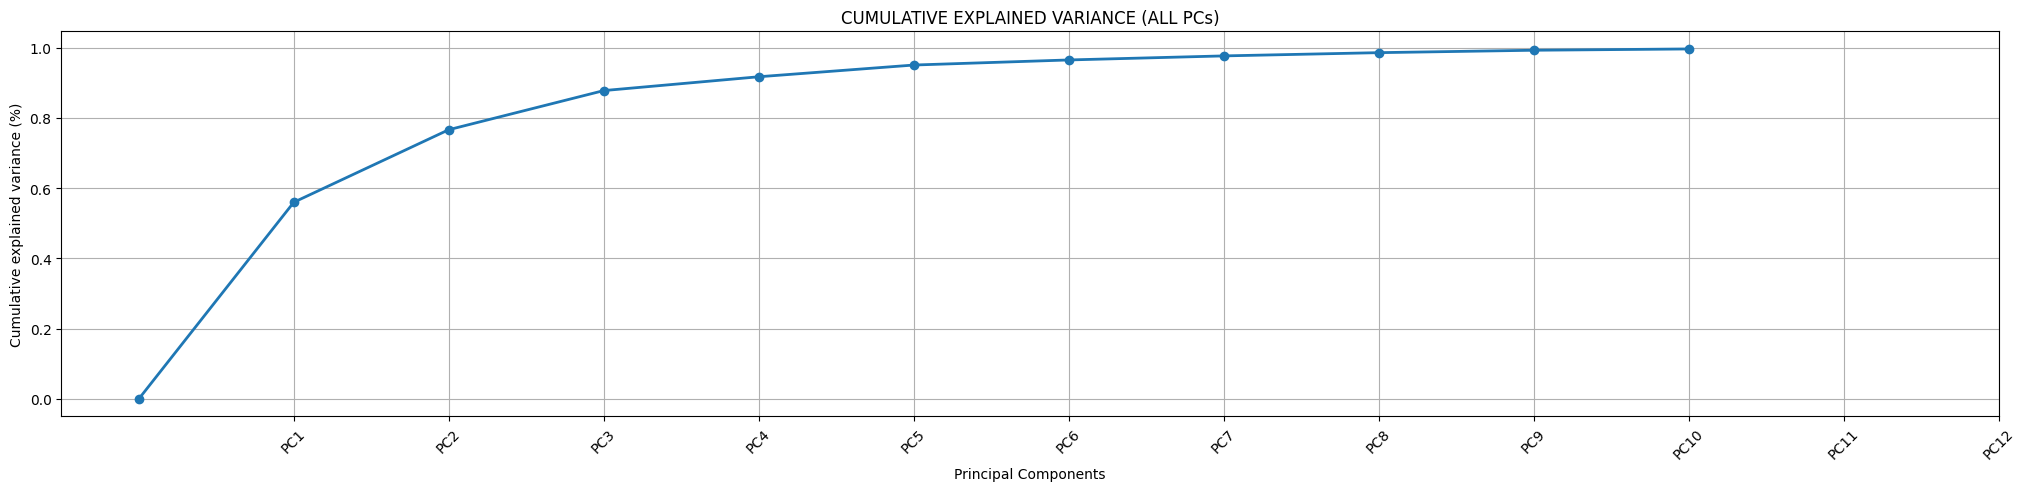

In [8]:
# MAKE THE CUMULATIVE EXPLAINED VARIANCE PLOT
plt.figure(figsize=(25, 5))
plt.plot(np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0), 'o-', linewidth=2)
plt.title('CUMULATIVE EXPLAINED VARIANCE (ALL PCs)')
plt.xticks(ticks=np.arange(1, pca.n_features_in_ + 1),
           labels=[f'PC{i}' for i in range(1, pca.n_features_in_ + 1)],
           rotation=45)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative explained variance (%)')
plt.grid()
plt.show()


In [9]:
tmp_df = data.copy()
tmp_df.drop('C6H6(GT)', axis=1, inplace=True)
target = data['C6H6(GT)']

Explained variance for 1 components (Before): 0.531380970792289
Explained variance for 2 components (Before): 0.7552125555064735
Explained variance for 3 components (Before): 0.876210531215828
Explained variance for 4 components (Before): 0.9154575134705428
Explained variance for 5 components (Before): 0.9505555659243273
Explained variance for 6 components (Before): 0.9659172340842053
Explained variance for 7 components (Before): 0.9783582595907152
Explained variance for 8 components (Before): 0.9866596406567759
Explained variance for 9 components (Before): 0.9941133930441884


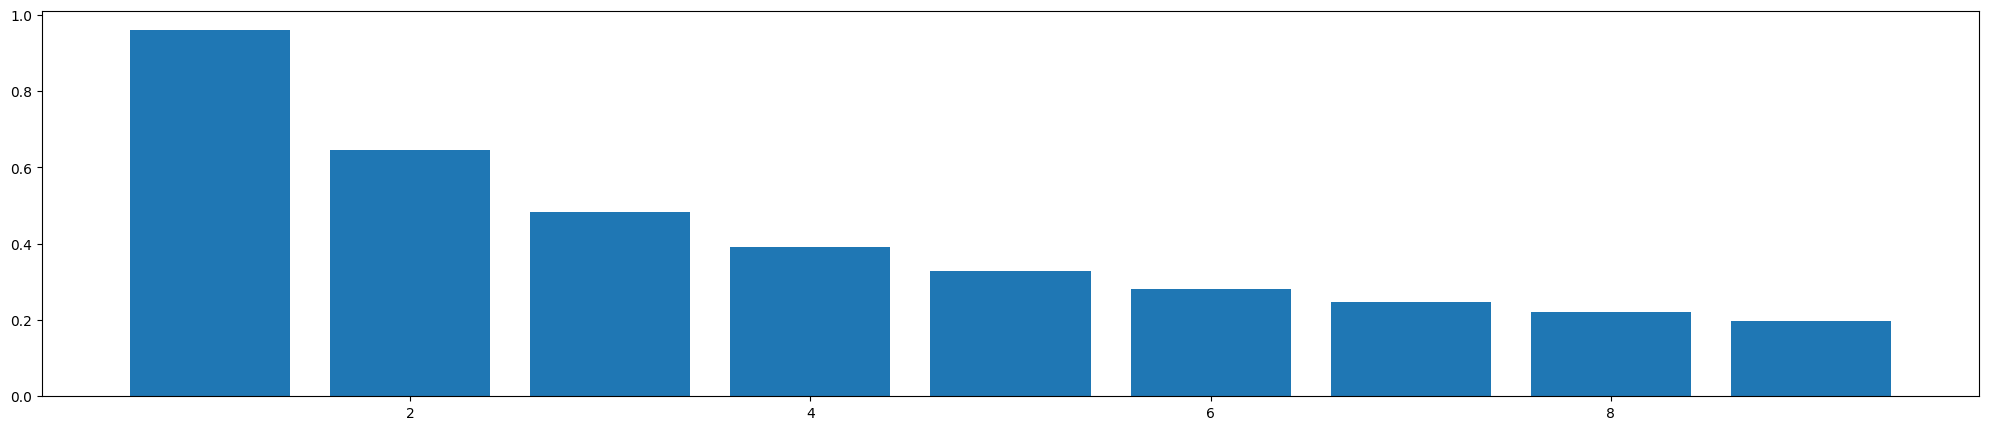

In [10]:
def explained_variance_experiment(X, y, n_components=9):
    variance_explained = []
    scaler = StandardScaler(copy=True)
    X = scaler.fit_transform(X)

    for i in range(1, n_components + 1):
        pca_1 = PCA(n_components=i)
        pca_2 = PCA(n_components=1)
        components = pca_1.fit_transform(X)
        new_X = np.column_stack((components, y))
        new_X = scaler.fit_transform(new_X)
        pca_2.fit_transform(new_X)
        print(f"Explained variance for {i} components (Before): {pca_1.explained_variance_ratio_.sum()}")
        variance_explained.append(pca_2.explained_variance_ratio_.sum())

    plt.figure(figsize=(25, 5))
    plt.bar(range(1, n_components + 1), variance_explained)

    plt.show()


explained_variance_experiment(tmp_df.values, target.values)

In [11]:
pca_1 = PCA(n_components=1)
pca_2 = PCA(n_components=1)
components = pca_1.fit_transform(tmp_df.values)
comps_X = np.column_stack((components,target.values))
new_X = scaler.fit_transform(comps_X)
new_X = pca_2.fit_transform(new_X)

new_X

array([[ 0.78493259],
       [ 1.13477878],
       [ 1.07156937],
       ...,
       [ 0.33450812],
       [-0.40949118],
       [-0.01795292]])

In [12]:
aux = pd.DataFrame(zip(data.index, new_X), columns=['date', 'target'])
aux.target = aux.target.astype(float)
aux.date = pd.to_datetime(aux.date)
aux['id_time_series'] = '0'
aux

,date,target,id_time_series
0,2004-03-16 15:00:00,0.784933,0
1,2004-03-16 16:00:00,1.134779,0
2,2004-03-16 17:00:00,1.071569,0
3,2004-03-16 18:00:00,1.296027,0
4,2004-03-16 19:00:00,1.635717,0
...,...,...,...
9211,2005-04-04 10:00:00,1.096456,0
9212,2005-04-04 11:00:00,0.380370,0
9213,2005-04-04 12:00:00,0.334508,0
9214,2005-04-04 13:00:00,-0.409491,0


In [13]:
train_data = TimeSeriesDataFrame.from_data_frame(
    aux,
    id_column="id_time_series",
    timestamp_column="date"
)
#train_data = train_data.convert_frequency(freq="d")
train_data

target
item_id timestamp                    
0       2004-03-16 15:00:00  0.784933
        2004-03-16 16:00:00  1.134779
        2004-03-16 17:00:00  1.071569
        2004-03-16 18:00:00  1.296027
        2004-03-16 19:00:00  1.635717
...                               ...
        2005-04-04 10:00:00  1.096456
        2005-04-04 11:00:00  0.380370
        2005-04-04 12:00:00  0.334508
        2005-04-04 13:00:00 -0.409491
        2005-04-04 14:00:00 -0.017953

[9216 rows x 1 columns]

In [14]:
use_cuda = torch.cuda.is_available()
print(
    f"We will use {'chronos_small' if use_cuda else 'bolt_small'} because cuda is {'not ' if not use_cuda else ''}available")

We will use chronos_small because cuda is available


In [15]:
predictor = TimeSeriesPredictor(prediction_length=15).fit(
    train_data, presets="chronos_base" if use_cuda else "bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to '/home/antares/Documents/PoliTo/Fall_24/DeepNLP/DeepNLP_Forecasting/AutogluonModels/ag-20250711_170157'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #202412060638~1751390742~22.04~79b9668 SMP PREEMPT_DYNAMIC Tue J
CPU Count:          16
GPU Count:          1
Memory Avail:       2.79 GB / 15.32 GB (18.2%)
Disk Space Avail:   302.96 GB / 441.91 GB (68.6%)
Setting presets to: chronos_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 15,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2

Model not specified in predict, will default to the model with the best validation score: Chronos[base]


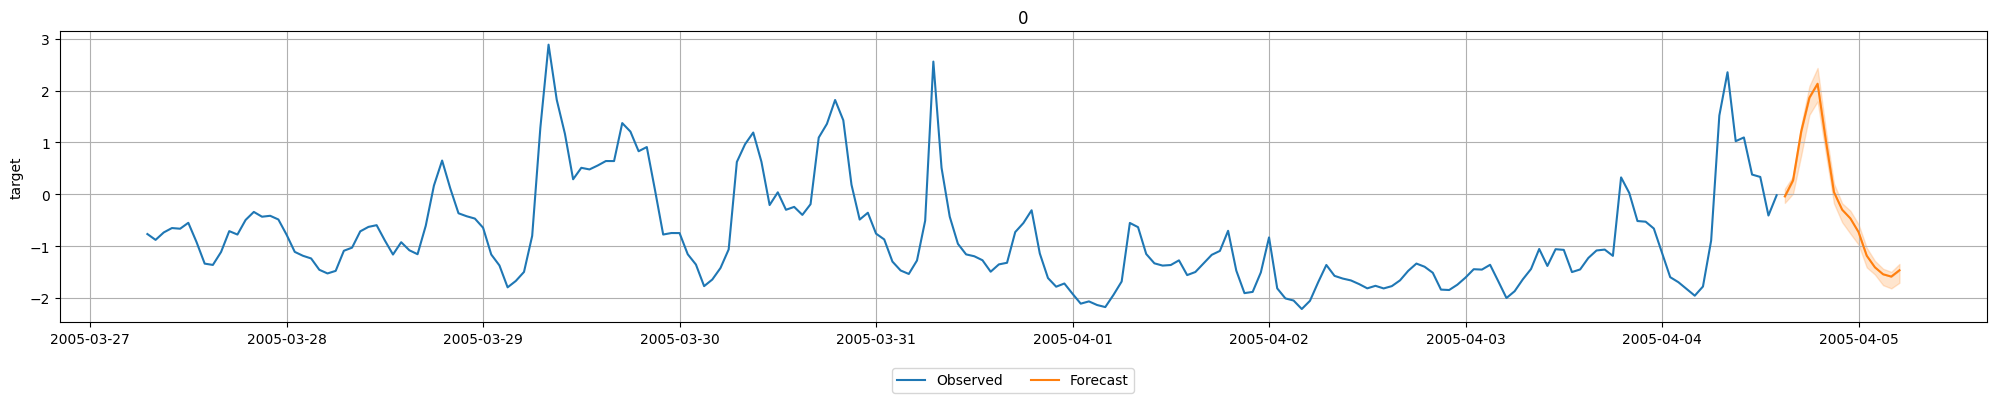

In [16]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=train_data,
    predictions=predictions,
    item_ids=train_data.item_ids[0],
    max_history_length=200,
);

In [17]:
temp_df = pd.DataFrame(new_X, columns=['target'], index=data.index)
temp_df.index = pd.to_datetime(temp_df.index)

In [18]:
temp_df

,target
Date_Time,
2004-03-16 15:00:00,0.784933
2004-03-16 16:00:00,1.134779
2004-03-16 17:00:00,1.071569
2004-03-16 18:00:00,1.296027
2004-03-16 19:00:00,1.635717
...,...
2005-04-04 10:00:00,1.096456
2005-04-04 11:00:00,0.380370
2005-04-04 12:00:00,0.334508


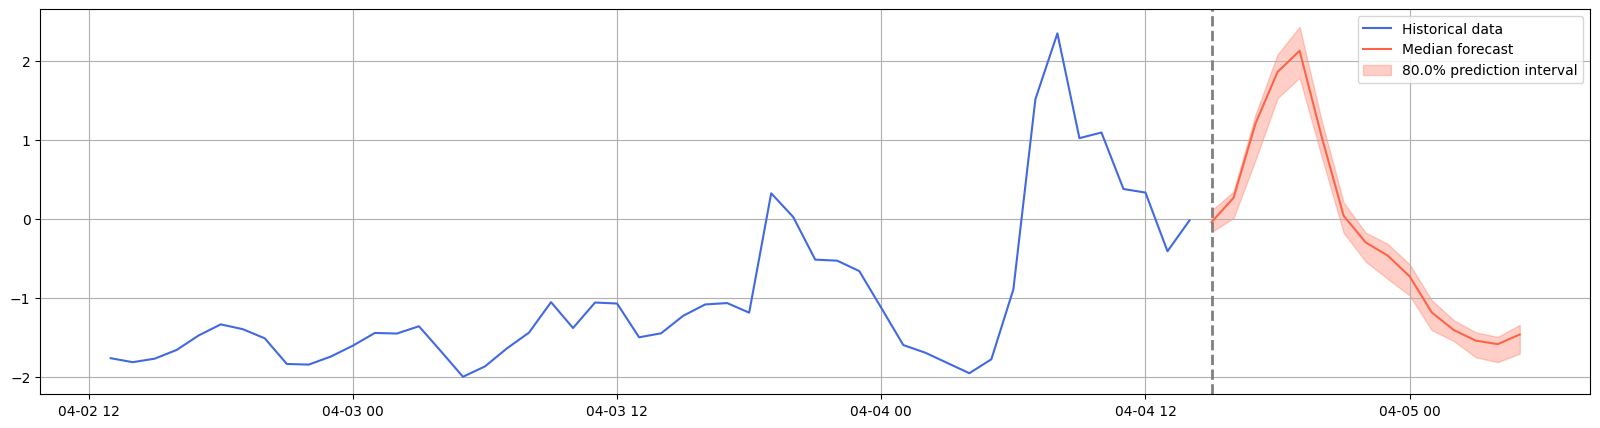

In [19]:
low, median, high = predictions.loc[:, "0.1"], predictions.loc[:, "0.5"], predictions.loc[:, "0.9"]
plot_timeseries_forecasting(temp_df.tail(50), low, median, high, prediction_length=15, freq='h' )

In [20]:
prediction_length = 15
predictions2 = predictor.predict(train_data.iloc[: -prediction_length])

Model not specified in predict, will default to the model with the best validation score: Chronos[base]


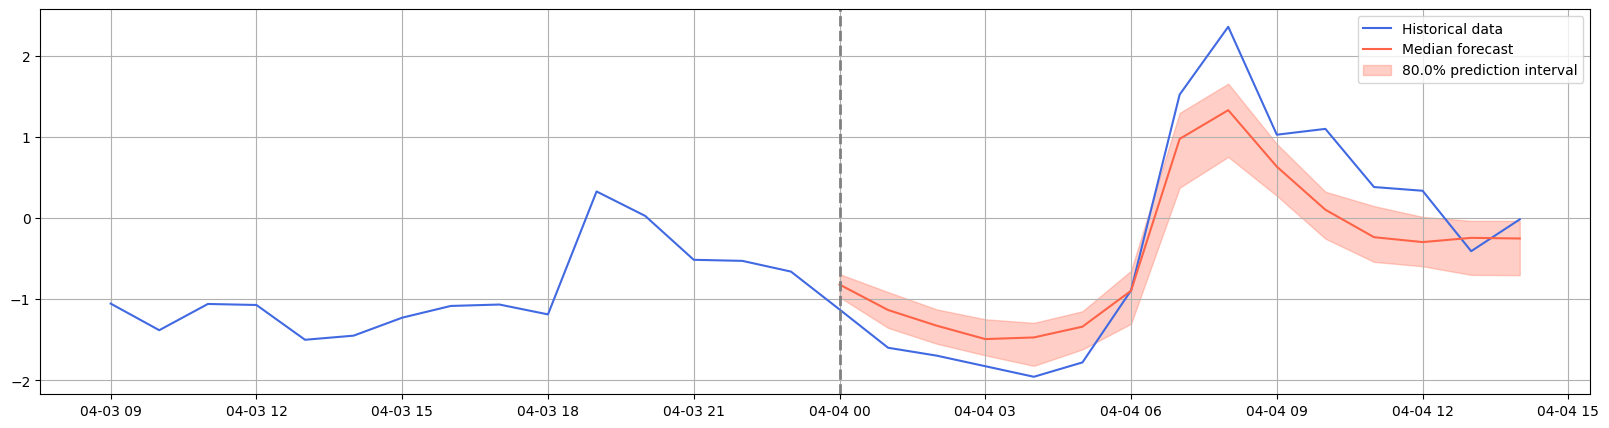

In [21]:
low, median, high = predictions2.loc[:, "0.1"], predictions2.loc[:, "0.5"], predictions2.loc[:, "0.9"]
start_forecasting_date = train_data.index.get_level_values("timestamp")[-prediction_length]
plot_timeseries_forecasting(temp_df.tail(30), low, median, high,
                            start_forecasting_date=start_forecasting_date,
                            prediction_length=prediction_length, freq='h')

In [22]:
predicted_series = temp_df.copy()
for i in pd.date_range(start=start_forecasting_date, periods=prediction_length, freq='h'):
    predicted_series.loc[str(i)].target = predictions2.loc[('0',str(i)),'0.5']
predicted_series.tail(15)

,target
Date_Time,
2005-04-04 00:00:00,-0.820326
2005-04-04 01:00:00,-1.133981
2005-04-04 02:00:00,-1.326999
2005-04-04 03:00:00,-1.491868
2005-04-04 04:00:00,-1.471762
2005-04-04 05:00:00,-1.339062
2005-04-04 06:00:00,-0.896729
2005-04-04 07:00:00,0.973132
2005-04-04 08:00:00,1.326999


In [23]:
predicted_series = pca_2.inverse_transform(predicted_series.values)
predicted_series

array([[ 0.55503116,  0.55503116],
       [ 0.80240977,  0.80240977],
       [ 0.75771397,  0.75771397],
       ...,
       [-0.21041336, -0.21041336],
       [-0.17344884, -0.17344884],
       [-0.1791357 , -0.1791357 ]])

In [24]:
# lets rebuild original data
predicted_series = scaler.inverse_transform(predicted_series)
predicted_series

array([[ 347.34561719,   14.32438457],
       [ 502.15832593,   16.17938682],
       [ 474.18712025,   15.84422926],
       ...,
       [-131.67937768,    8.58459452],
       [-108.54651065,    8.86177797],
       [-112.10541631,    8.81913433]])

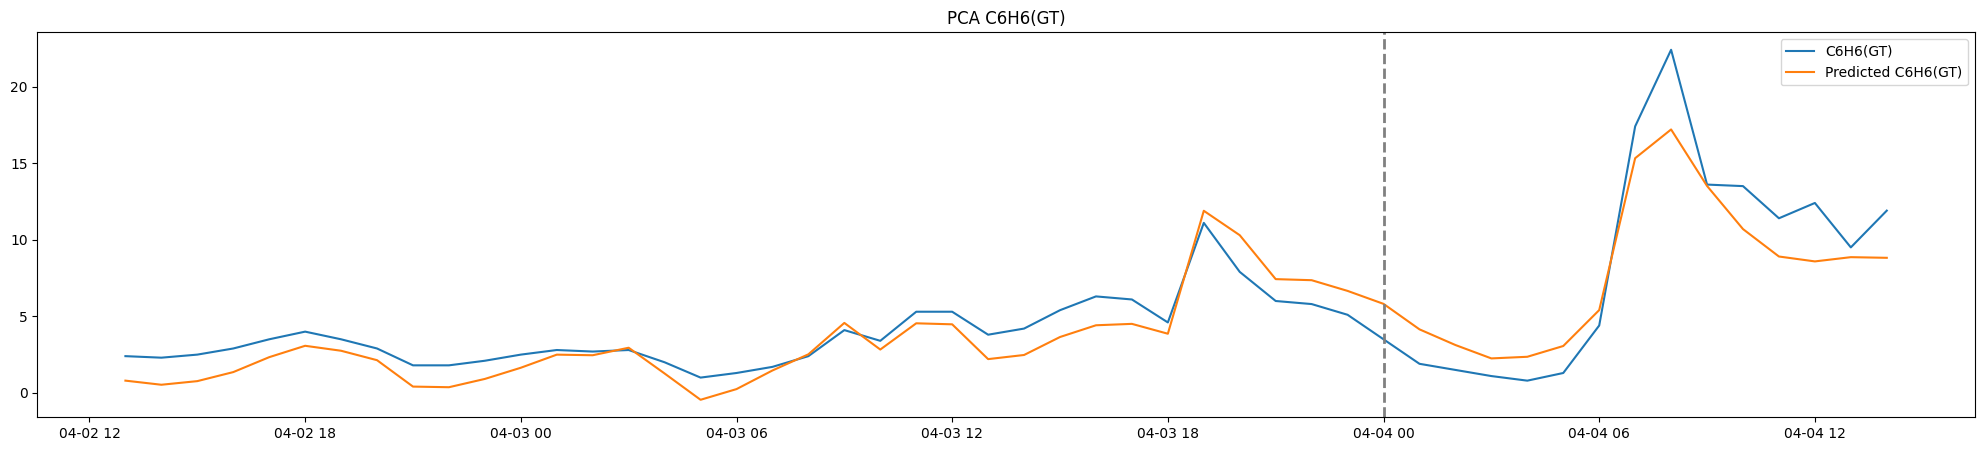

In [25]:
plt.figure(figsize=(25, 5))
plt.plot(data.index.values[-50:], data.values[-50:,2], label='C6H6(GT)')
plt.plot(data.index.values[-50:], predicted_series[-50:,1], label='Predicted C6H6(GT)')
plt.axvline(x=start_forecasting_date, color='gray', linestyle='--', linewidth=2)
plt.title('PCA C6H6(GT)')
plt.legend(loc='best')

## AutoEncoder

Model is already trained with the dataset to perform a reconstruction task.

In [26]:
%%writefile tsa/config.yaml

data:
  _target_: tsa.dataset.TimeSeriesDataset
  batch_size: 64
  categorical_cols: [ ]
  index_col: "Date_Time"
  target_col: [ ]
  data_path: "../Data/AirQuality.csv"
  prediction_window: 1
  seq_length: 30
  task:
    _target_: tsa.dataset.Tasks
    value: reconstruction

training:
  denoising: False
  directions: 1
  gradient_accumulation_steps: 1
  hidden_size_encoder: 64
  hidden_size_decoder: 64
  input_att: True
  lr: 1e-5
  lrs_step_size: 5000
  max_grad_norm: 0.1
  num_epochs: 100
  output_size: 12
  reg1: True
  reg2: False
  reg_factor1: 1e-4
  reg_factor2: 1e-4
  seq_len: ${data.seq_length}
  temporal_att: True

general:
  do_eval: False
  do_train: False
  get_latent: True
  logging_steps: 100

  output_dir: "output"
  save_steps: 5000
  eval_during_training: True

  ckpt: "tsa/checkpoint/final.ckpt"


Overwriting tsa/config.yaml


In [27]:
%run run_Autoencoder.py


Loading checkpoint: tsa/checkpoint/final.ckpt ...
current dir:  /home/antares/Documents/PoliTo/Fall_24/DeepNLP/DeepNLP_Forecasting


Batch 2: 100%|██████████| 28/28 [00:00<00:00, 75.86it/s]


In [28]:
obj = pd.read_pickle('Data/latent.pkl')
obj

array([[0.08159219],
       [0.09321515],
       [0.08433957],
       ...,
       [0.0122136 ],
       [0.01110001],
       [0.01446564]], dtype=float32)

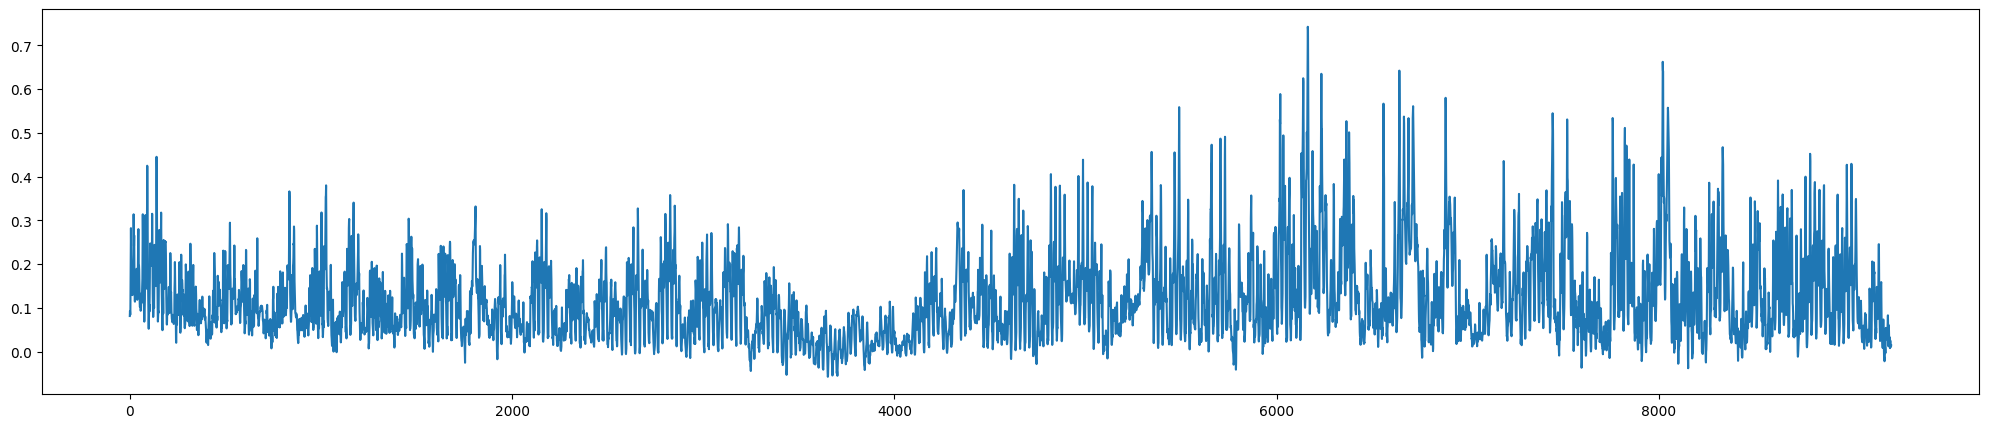

In [29]:
plt.figure(figsize=(25, 5))
plt.plot(obj);

In [30]:
autoenc_df = pd.DataFrame(obj, columns=['target'], index=data.index)
autoenc_df.index = pd.to_datetime(autoenc_df.index)
autoenc_df.index.names = ['timestamp']
autoenc_df['timestamp'] =autoenc_df.index
autoenc_df['id'] = '0'

In [31]:
autoenc_df

,target,timestamp,id
timestamp,,,
2004-03-16 15:00:00,0.081592,2004-03-16 15:00:00,0
2004-03-16 16:00:00,0.093215,2004-03-16 16:00:00,0
2004-03-16 17:00:00,0.084340,2004-03-16 17:00:00,0
2004-03-16 18:00:00,0.085476,2004-03-16 18:00:00,0
2004-03-16 19:00:00,0.159524,2004-03-16 19:00:00,0
...,...,...,...
2005-04-04 10:00:00,0.025518,2005-04-04 10:00:00,0
2005-04-04 11:00:00,0.015240,2005-04-04 11:00:00,0
2005-04-04 12:00:00,0.012214,2005-04-04 12:00:00,0


In [32]:
timeseries_AE = TimeSeriesDataFrame.from_data_frame(autoenc_df, id_column="id", timestamp_column="timestamp")
timeseries_AE

target
item_id timestamp                    
0       2004-03-16 15:00:00  0.081592
        2004-03-16 16:00:00  0.093215
        2004-03-16 17:00:00  0.084340
        2004-03-16 18:00:00  0.085476
        2004-03-16 19:00:00  0.159524
...                               ...
        2005-04-04 10:00:00  0.025518
        2005-04-04 11:00:00  0.015240
        2005-04-04 12:00:00  0.012214
        2005-04-04 13:00:00  0.011100
        2005-04-04 14:00:00  0.014466

[9216 rows x 1 columns]

In [33]:
predictor = TimeSeriesPredictor(prediction_length=15).fit(
    timeseries_AE, presets="chronos_base" if use_cuda else "bolt_small",
)
prediction_length = 15
predictions_AE = predictor.predict(timeseries_AE.iloc[: -prediction_length])

No path specified. Models will be saved in: "AutogluonModels/ag-20250711_170214"
Beginning AutoGluon training...
AutoGluon will save models to '/home/antares/Documents/PoliTo/Fall_24/DeepNLP/DeepNLP_Forecasting/AutogluonModels/ag-20250711_170214'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #202412060638~1751390742~22.04~79b9668 SMP PREEMPT_DYNAMIC Tue J
CPU Count:          16
GPU Count:          1
Memory Avail:       2.06 GB / 15.32 GB (13.5%)
Disk Space Avail:   302.96 GB / 441.91 GB (68.6%)
Setting presets to: chronos_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 15,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_

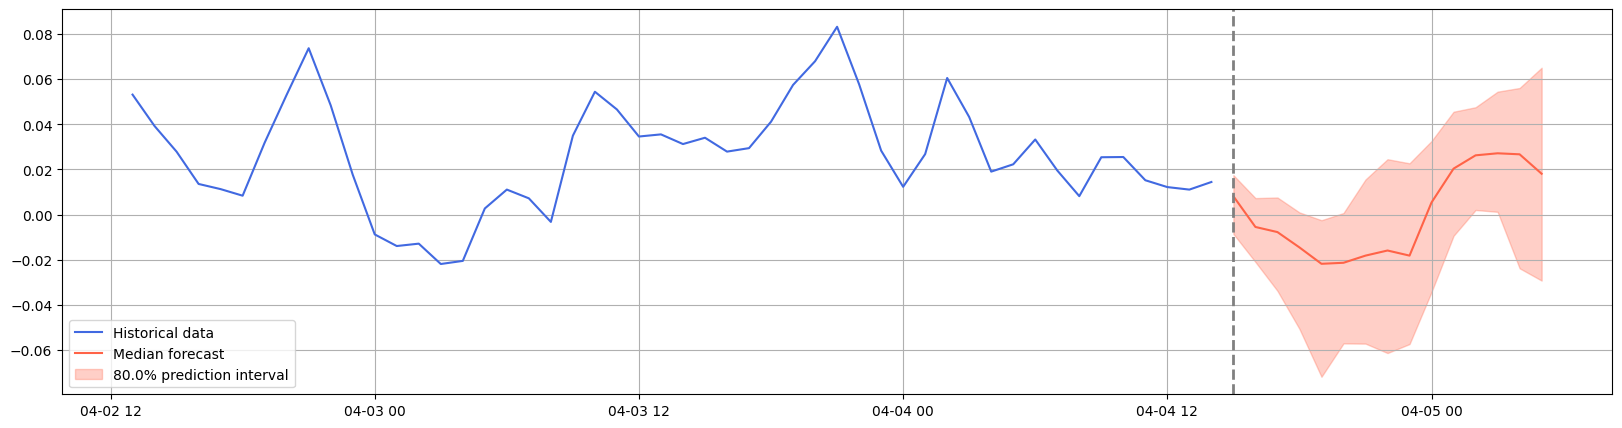

In [34]:
low, median, high = predictions_AE.loc[:, "0.1"], predictions_AE.loc[:, "0.5"], predictions_AE.loc[:, "0.9"]
plot_timeseries_forecasting(autoenc_df['target'].tail(50), low, median, high, prediction_length=15, freq='h')

In [35]:
autoenc_df['target'].tail(10)

timestamp
2005-04-04 05:00:00    0.022298
2005-04-04 06:00:00    0.033278
2005-04-04 07:00:00    0.019571
2005-04-04 08:00:00    0.008201
2005-04-04 09:00:00    0.025419
2005-04-04 10:00:00    0.025518
2005-04-04 11:00:00    0.015240
2005-04-04 12:00:00    0.012214
2005-04-04 13:00:00    0.011100
2005-04-04 14:00:00    0.014466
Name: target, dtype: float32

Model not specified in predict, will default to the model with the best validation score: Chronos[base]


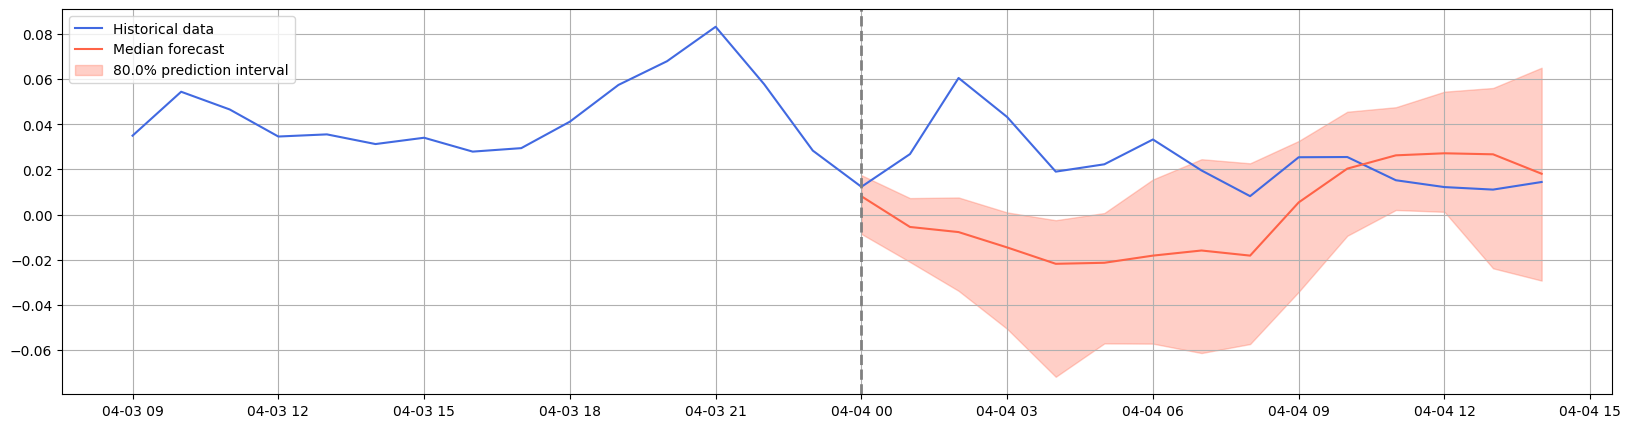

In [36]:
prediction_length = 15
predictions2 = predictor.predict(timeseries_AE.iloc[: -prediction_length])
low, median, high = predictions2.loc[:, "0.1"], predictions2.loc[:, "0.5"], predictions2.loc[:, "0.9"]
start_forecasting_date = timeseries_AE.index.get_level_values("timestamp")[-prediction_length]
plot_timeseries_forecasting(autoenc_df['target'].tail(30), low, median, high,
                            start_forecasting_date=start_forecasting_date,
                            prediction_length=prediction_length, freq='h')


In [37]:
predicted_series = autoenc_df.target.copy(deep=True)
for i in pd.date_range(start=start_forecasting_date, periods=prediction_length, freq='h'):
    predicted_series.loc[str(i)] = predictions2.loc[('0',str(i)),'0.5']
predicted_series

timestamp
2004-03-16 15:00:00    0.081592
2004-03-16 16:00:00    0.093215
2004-03-16 17:00:00    0.084340
2004-03-16 18:00:00    0.085476
2004-03-16 19:00:00    0.159524
                         ...   
2005-04-04 10:00:00    0.020377
2005-04-04 11:00:00    0.026264
2005-04-04 12:00:00    0.027170
2005-04-04 13:00:00    0.026717
2005-04-04 14:00:00    0.018113
Name: target, Length: 9216, dtype: float32

In [38]:
with open('Data/new_latenl.pkl', 'wb') as f:
    pickle.dump(predicted_series.values.reshape(-1,1), f)

In [39]:
%%writefile tsa/config.yaml

data:
  _target_: tsa.dataset.TimeSeriesDataset
  batch_size: 64
  categorical_cols: [ ]
  index_col: "Date_Time"
  target_col: [ ]
  data_path: "../Data/AirQuality.csv"
  prediction_window: 1
  seq_length: 30
  task:
    _target_: tsa.dataset.Tasks
    value: reconstruction

training:
  denoising: False
  directions: 1
  gradient_accumulation_steps: 1
  hidden_size_encoder: 64
  hidden_size_decoder: 64
  input_att: True
  lr: 1e-5
  lrs_step_size: 5000
  max_grad_norm: 0.1
  num_epochs: 100
  output_size: 12
  reg1: True
  reg2: False
  reg_factor1: 1e-4
  reg_factor2: 1e-4
  seq_len: ${data.seq_length}
  temporal_att: True

general:
  do_eval: False
  do_train: False
  get_latent: False
  decode_latent: True
  logging_steps: 100

  output_dir: "output"
  save_steps: 5000
  eval_during_training: True

  ckpt: "tsa/checkpoint/final.ckpt"
  latent_path: "../Data/new_latenl.pkl"


Overwriting tsa/config.yaml


In [40]:
%run run_Autoencoder.py

Loading checkpoint: tsa/checkpoint/final.ckpt ...
current dir:  /home/antares/Documents/PoliTo/Fall_24/DeepNLP/DeepNLP_Forecasting


Batch 2: 100%|██████████| 28/28 [00:00<00:00, 89.01it/s]


In [41]:
with open('Data/decoded_data.pkl', 'rb') as f:
    decoded_data = pickle.load(f)
decoded_data

array([[ 0.26576912, -0.40276504,  0.5364462 , ..., -0.25804323,
         0.64861286,  0.3504246 ],
       [ 0.26609504, -0.50753176,  0.6026234 , ..., -0.17337038,
         0.71637803,  0.4591505 ],
       [ 0.28651798, -0.53039944,  0.5777114 , ..., -0.17289546,
         0.72288734,  0.48332348],
       ...,
       [-0.47019374,  0.20776297, -0.45539564, ..., -0.8086455 ,
        -0.26358813, -0.43754658],
       [-0.49065572,  0.2587993 , -0.48725528, ..., -0.82115024,
        -0.30740404, -0.45522064],
       [-0.52090627,  0.3078696 , -0.53127205, ..., -0.8332475 ,
        -0.33841604, -0.46183366]], dtype=float32)

In [42]:
decoded_data = pd.DataFrame(decoded_data, columns=data.columns, index=data.index)
decoded_data

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
timestamp,,,,,,,,,,,,
2004-03-16 15:00:00,0.265769,-0.402765,0.536446,0.558480,0.185294,0.039632,-0.059347,0.047753,0.517208,-0.258043,0.648613,0.350425
2004-03-16 16:00:00,0.266095,-0.507532,0.602623,0.606770,0.313369,0.046247,-0.148810,0.089218,0.600014,-0.173370,0.716378,0.459150
2004-03-16 17:00:00,0.286518,-0.530399,0.577711,0.628878,0.337334,0.033032,-0.178055,0.102456,0.610431,-0.172895,0.722887,0.483323
2004-03-16 18:00:00,0.218798,-0.488018,0.563075,0.705121,0.275736,-0.017691,-0.122414,0.073488,0.584958,-0.217265,0.718532,0.479318
2004-03-16 19:00:00,0.100482,-0.474673,0.626236,0.763915,0.230861,-0.026290,-0.034596,0.063734,0.577393,-0.247762,0.746900,0.541052
...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,-0.417126,0.057448,-0.334086,0.121311,-0.122633,-0.665123,-0.516825,-0.422953,-0.028555,-0.767222,-0.115400,-0.395702
2005-04-04 11:00:00,-0.443481,0.139847,-0.410233,0.068013,-0.202313,-0.720180,-0.469080,-0.484663,-0.097698,-0.781847,-0.204965,-0.421340
2005-04-04 12:00:00,-0.470194,0.207763,-0.455396,0.038912,-0.260293,-0.763362,-0.426986,-0.524941,-0.149666,-0.808645,-0.263588,-0.437547


In [43]:
with open('Data/target.pkl', 'rb') as f:
    target = pickle.load(f)
target = pd.DataFrame(target, columns=data.columns, index=data.index)
target

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
timestamp,,,,,,,,,,,,
2004-03-16 15:00:00,-0.201580,-1.332489,0.212917,0.611965,-0.505554,-0.470238,-1.544815,-0.512430,-0.272422,-0.520747,1.556986,-0.566577
2004-03-16 16:00:00,-0.549299,-1.341197,-0.257390,0.732921,-0.920914,-0.724533,-1.618418,-0.870313,-0.525957,-0.761895,2.134979,-0.867440
2004-03-16 17:00:00,-0.966563,-1.345278,-0.987604,0.761719,-1.459760,-0.876611,-1.630685,-1.330450,-0.974171,-1.143169,3.236657,-1.155223
2004-03-16 18:00:00,-1.036106,-1.348816,-1.717818,0.969071,-1.714215,-1.028690,-1.741090,-1.657658,-1.236760,-1.315883,4.062916,-1.259871
2004-03-16 19:00:00,-1.105650,-1.352897,-1.420782,0.917233,-1.732925,-0.983814,-1.716556,-1.632095,-1.164322,-1.247449,4.070674,-1.272952
...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,-0.966563,-1.454121,0.039646,-0.908612,-1.246467,-0.410404,-0.575705,-1.348344,-0.928896,-2.130572,0.424275,-1.050575
2005-04-04 11:00:00,-0.827475,-1.548543,0.014893,-1.098684,-1.235241,-0.385473,-0.489835,-1.435259,-0.969643,-2.221817,0.412638,-1.050575
2005-04-04 12:00:00,-0.966563,-1.678610,-0.158378,-1.323315,-1.242725,-0.445307,-0.403964,-1.563074,-1.028499,-2.293510,0.571683,-1.050575


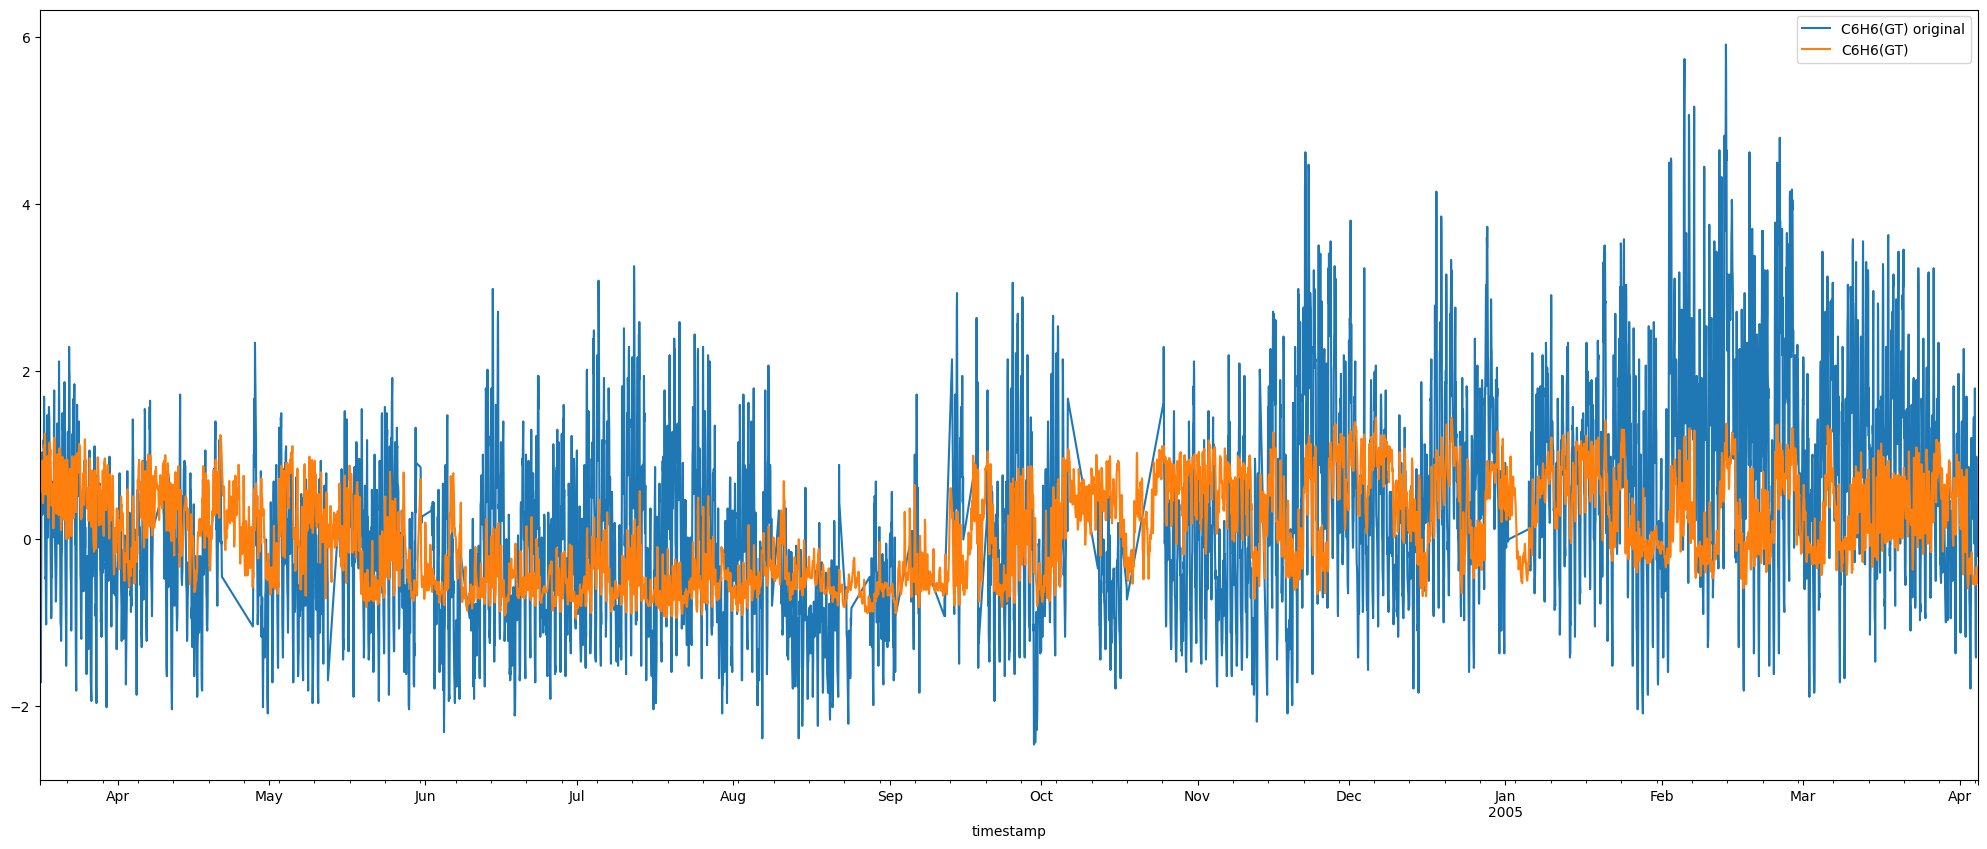

In [44]:
plt.figure(figsize=(25,10))
target['C6H6(GT)'].plot(label='C6H6(GT) original')
decoded_data['C6H6(GT)'].plot(label='C6H6(GT)')
plt.legend()

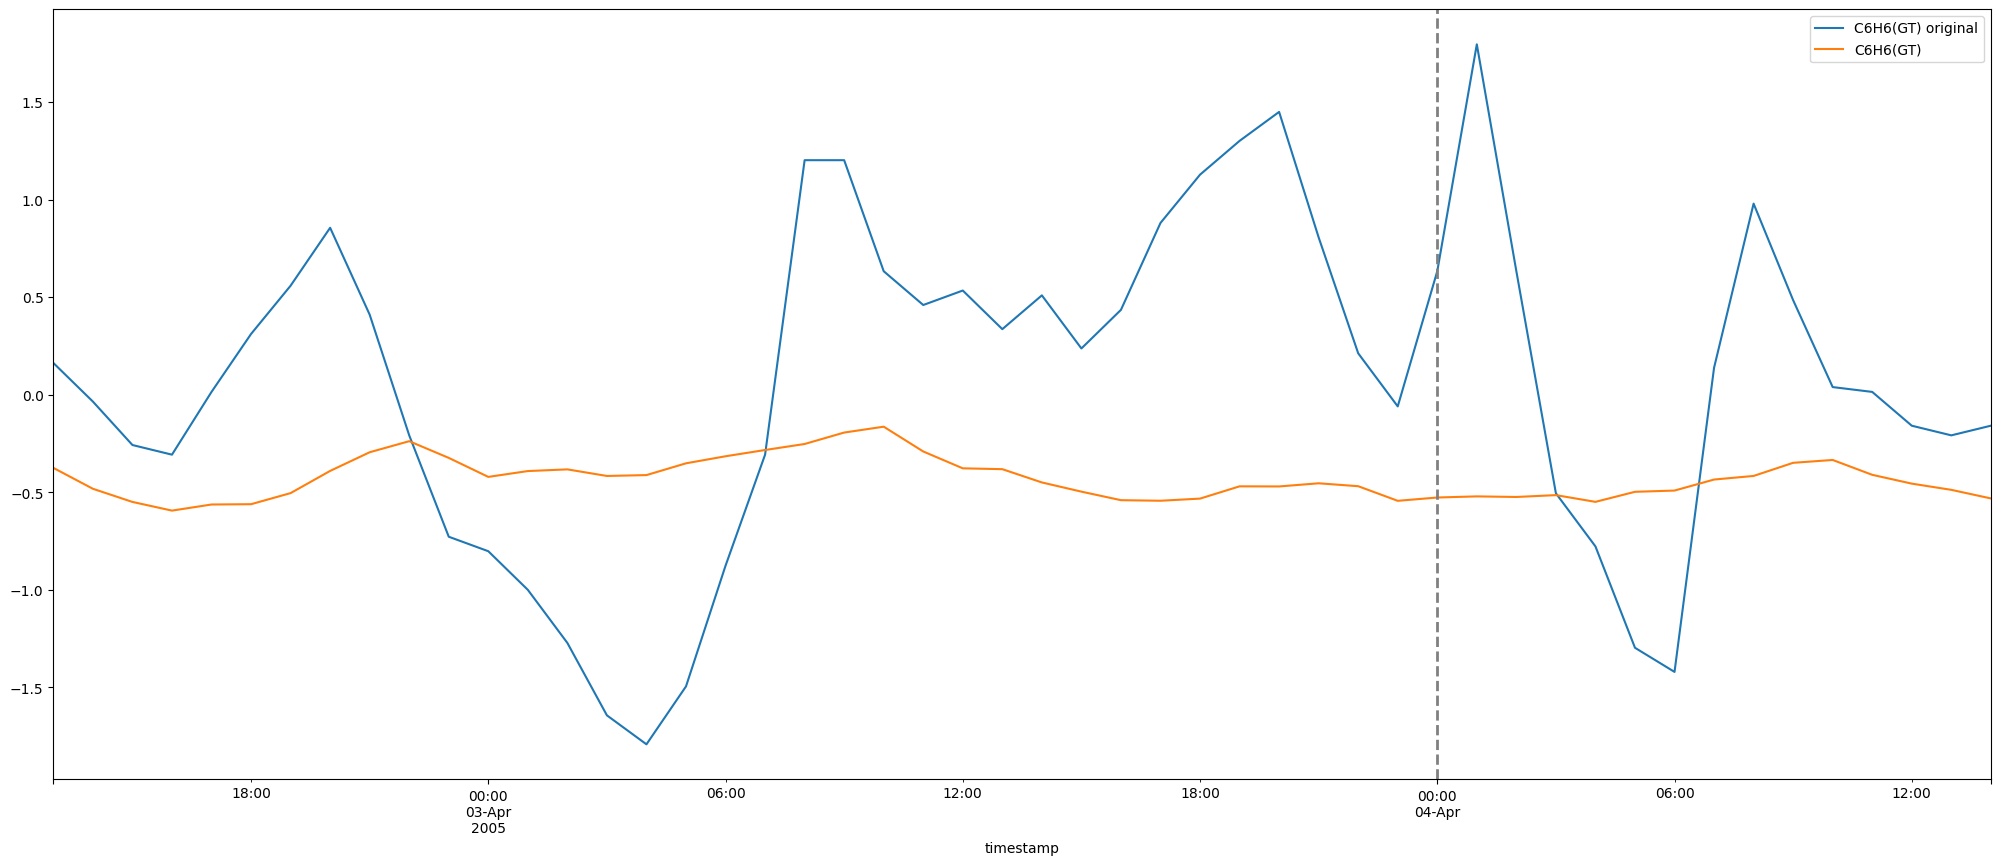

In [45]:
plt.figure(figsize=(25,10))
target['C6H6(GT)'].tail(50).plot(label='C6H6(GT) original')
decoded_data['C6H6(GT)'].tail(50).plot(label='C6H6(GT)')
plt.axvline(x=start_forecasting_date, color='gray', linestyle='--', linewidth=2)
plt.legend()

## Auutogluon Covariate forecasting


In [46]:
df_forecast = data.copy()
df_forecast['timestamp'] = df_forecast.index
df_forecast['id'] = '0'

In [47]:
timeseries = TimeSeriesDataFrame.from_data_frame(df_forecast, id_column="id", timestamp_column="timestamp")
timeseries

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  \
item_id timestamp                                                           
0       2004-03-16 15:00:00     2.8       1280.0      14.6         1136.0   
        2004-03-16 16:00:00     2.9       1407.0      16.6         1197.0   
        2004-03-16 17:00:00     2.9       1389.0      15.8         1173.0   
        2004-03-16 18:00:00     3.4       1447.0      17.8         1235.0   
        2004-03-16 19:00:00     3.9       1551.0      19.1         1271.0   
...                             ...          ...       ...            ...   
        2005-04-04 10:00:00     3.1       1314.0      13.5         1101.0   
        2005-04-04 11:00:00     2.4       1163.0      11.4         1027.0   
        2005-04-04 12:00:00     2.4       1142.0      12.4         1063.0   
        2005-04-04 13:00:00     2.1       1003.0       9.5          961.0   
        2005-04-04 14:00:00     2.2       1071.0      11.9         1047.0   

                             NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
item_id timestamp                                                           
0       2004-03-16 15:00:00    180.0         893.0    128.0        1675.0   
        2004-03-16 16:00:00    184.0         905.0    129.0        1759.0   
        2004-03-16 17:00:00    190.0         898.0    133.0        1739.0   
        2004-03-16 18:00:00    184.0         859.0    139.0        1778.0   
        2004-03-16 19:00:00    181.0         800.0    137.0        1875.0   
...                              ...           ...      ...           ...   
        2005-04-04 10:00:00    472.0         539.0    190.0        1374.0   
        2005-04-04 11:00:00    353.0         604.0    179.0        1264.0   
        2005-04-04 12:00:00    293.0         603.0    175.0        1241.0   
        2005-04-04 13:00:00    235.0         702.0    156.0        1041.0   
        2005-04-04 14:00:00    265.0         654.0    168.0        1129.0   

                             PT08.S5(O3)     T    RH      AH  
item_id timestamp                                             
0       2004-03-16 15:00:00       1240.0  27.0  20.2  0.7094  
        2004-03-16 16:00:00       1313.0  28.2  18.6  0.7014  
        2004-03-16 17:00:00       1363.0  28.0  19.1  0.7098  
        2004-03-16 18:00:00       1296.0  23.9  25.7  0.7519  
        2004-03-16 19:00:00       1432.0  21.3  34.8  0.8730  
...                                  ...   ...   ...     ...  
        2005-04-04 10:00:00       1729.0  21.9  29.3  0.7568  
        2005-04-04 11:00:00       1269.0  24.3  23.7  0.7119  
        2005-04-04 12:00:00       1092.0  26.9  18.3  0.6406  
        2005-04-04 13:00:00        770.0  28.3  13.5  0.5139  
        2005-04-04 14:00:00        816.0  28.5  13.1  0.5028  

[9216 rows x 12 columns]

In [48]:
prediction_length = 10
train_data, test_data = timeseries.train_test_split(prediction_length=prediction_length)

In [49]:
train_data

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  \
item_id timestamp                                                           
0       2004-03-16 15:00:00    2.80       1280.0      14.6         1136.0   
        2004-03-16 16:00:00    2.90       1407.0      16.6         1197.0   
        2004-03-16 17:00:00    2.90       1389.0      15.8         1173.0   
        2004-03-16 18:00:00    3.40       1447.0      17.8         1235.0   
        2004-03-16 19:00:00    3.90       1551.0      19.1         1271.0   
...                             ...          ...       ...            ...   
        2005-04-04 00:00:00    0.90       1012.0       3.5          683.0   
        2005-04-04 01:00:00    0.60        944.0       1.9          579.0   
        2005-04-04 02:00:00    0.50        912.0       1.5          544.0   
        2005-04-04 03:00:00    0.40        887.0       1.1          508.0   
        2005-04-04 04:00:00    0.45        864.0       0.8          478.0   

                             NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
item_id timestamp                                                           
0       2004-03-16 15:00:00    180.0         893.0    128.0        1675.0   
        2004-03-16 16:00:00    184.0         905.0    129.0        1759.0   
        2004-03-16 17:00:00    190.0         898.0    133.0        1739.0   
        2004-03-16 18:00:00    184.0         859.0    139.0        1778.0   
        2004-03-16 19:00:00    181.0         800.0    137.0        1875.0   
...                              ...           ...      ...           ...   
        2005-04-04 00:00:00    117.0         801.0     93.0        1073.0   
        2005-04-04 01:00:00     70.0         925.0     58.0        1002.0   
        2005-04-04 02:00:00     69.0         959.0     55.0        1002.0   
        2005-04-04 03:00:00     62.0        1047.0     51.0         974.0   
        2005-04-04 04:00:00     52.0        1116.0     43.0         958.0   

                             PT08.S5(O3)     T    RH      AH  
item_id timestamp                                             
0       2004-03-16 15:00:00       1240.0  27.0  20.2  0.7094  
        2004-03-16 16:00:00       1313.0  28.2  18.6  0.7014  
        2004-03-16 17:00:00       1363.0  28.0  19.1  0.7098  
        2004-03-16 18:00:00       1296.0  23.9  25.7  0.7519  
        2004-03-16 19:00:00       1432.0  21.3  34.8  0.8730  
...                                  ...   ...   ...     ...  
        2005-04-04 00:00:00        816.0  14.2  51.4  0.8275  
        2005-04-04 01:00:00        598.0  13.8  51.2  0.8058  
        2005-04-04 02:00:00        573.0  12.1  56.3  0.7927  
        2005-04-04 03:00:00        549.0  11.3  58.9  0.7888  
        2005-04-04 04:00:00        489.0  11.8  56.0  0.7743  

[9206 rows x 12 columns]

In [50]:
covar_labels = list(timeseries.columns)
covar_labels.remove('C6H6(GT)')
covar_labels

['CO(GT)',
 'PT08.S1(CO)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH']

In [51]:
covariates  = test_data.drop('C6H6(GT)', axis=1, inplace=False)
covariates[covar_labels].iloc[-prediction_length:]

CO(GT)  PT08.S1(CO)  PT08.S2(NMHC)  NOx(GT)  \
item_id timestamp                                                          
0       2005-04-04 05:00:00     0.5        888.0          528.0     77.0   
        2005-04-04 06:00:00     1.1       1031.0          730.0    182.0   
        2005-04-04 07:00:00     4.0       1384.0         1221.0    594.0   
        2005-04-04 08:00:00     5.0       1446.0         1362.0    586.0   
        2005-04-04 09:00:00     3.9       1297.0         1102.0    523.0   
        2005-04-04 10:00:00     3.1       1314.0         1101.0    472.0   
        2005-04-04 11:00:00     2.4       1163.0         1027.0    353.0   
        2005-04-04 12:00:00     2.4       1142.0         1063.0    293.0   
        2005-04-04 13:00:00     2.1       1003.0          961.0    235.0   
        2005-04-04 14:00:00     2.2       1071.0         1047.0    265.0   

                             PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
item_id timestamp                                                               
0       2005-04-04 05:00:00        1077.0     53.0         987.0        578.0   
        2005-04-04 06:00:00         760.0     93.0        1129.0        905.0   
        2005-04-04 07:00:00         470.0    155.0        1600.0       1457.0   
        2005-04-04 08:00:00         415.0    174.0        1777.0       1705.0   
        2005-04-04 09:00:00         507.0    187.0        1375.0       1583.0   
        2005-04-04 10:00:00         539.0    190.0        1374.0       1729.0   
        2005-04-04 11:00:00         604.0    179.0        1264.0       1269.0   
        2005-04-04 12:00:00         603.0    175.0        1241.0       1092.0   
        2005-04-04 13:00:00         702.0    156.0        1041.0        770.0   
        2005-04-04 14:00:00         654.0    168.0        1129.0        816.0   

                                T    RH      AH  
item_id timestamp                                
0       2005-04-04 05:00:00  10.4  59.9  0.7550  
        2005-04-04 06:00:00   9.5  63.1  0.7531  
        2005-04-04 07:00:00   9.7  61.9  0.7446  
        2005-04-04 08:00:00  13.5  48.9  0.7553  
        2005-04-04 09:00:00  18.2  36.3  0.7487  
        2005-04-04 10:00:00  21.9  29.3  0.7568  
        2005-04-04 11:00:00  24.3  23.7  0.7119  
        2005-04-04 12:00:00  26.9  18.3  0.6406  
        2005-04-04 13:00:00  28.3  13.5  0.5139  
        2005-04-04 14:00:00  28.5  13.1  0.5028

In [52]:
test_data

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  \
item_id timestamp                                                           
0       2004-03-16 15:00:00     2.8       1280.0      14.6         1136.0   
        2004-03-16 16:00:00     2.9       1407.0      16.6         1197.0   
        2004-03-16 17:00:00     2.9       1389.0      15.8         1173.0   
        2004-03-16 18:00:00     3.4       1447.0      17.8         1235.0   
        2004-03-16 19:00:00     3.9       1551.0      19.1         1271.0   
...                             ...          ...       ...            ...   
        2005-04-04 10:00:00     3.1       1314.0      13.5         1101.0   
        2005-04-04 11:00:00     2.4       1163.0      11.4         1027.0   
        2005-04-04 12:00:00     2.4       1142.0      12.4         1063.0   
        2005-04-04 13:00:00     2.1       1003.0       9.5          961.0   
        2005-04-04 14:00:00     2.2       1071.0      11.9         1047.0   

                             NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
item_id timestamp                                                           
0       2004-03-16 15:00:00    180.0         893.0    128.0        1675.0   
        2004-03-16 16:00:00    184.0         905.0    129.0        1759.0   
        2004-03-16 17:00:00    190.0         898.0    133.0        1739.0   
        2004-03-16 18:00:00    184.0         859.0    139.0        1778.0   
        2004-03-16 19:00:00    181.0         800.0    137.0        1875.0   
...                              ...           ...      ...           ...   
        2005-04-04 10:00:00    472.0         539.0    190.0        1374.0   
        2005-04-04 11:00:00    353.0         604.0    179.0        1264.0   
        2005-04-04 12:00:00    293.0         603.0    175.0        1241.0   
        2005-04-04 13:00:00    235.0         702.0    156.0        1041.0   
        2005-04-04 14:00:00    265.0         654.0    168.0        1129.0   

                             PT08.S5(O3)     T    RH      AH  
item_id timestamp                                             
0       2004-03-16 15:00:00       1240.0  27.0  20.2  0.7094  
        2004-03-16 16:00:00       1313.0  28.2  18.6  0.7014  
        2004-03-16 17:00:00       1363.0  28.0  19.1  0.7098  
        2004-03-16 18:00:00       1296.0  23.9  25.7  0.7519  
        2004-03-16 19:00:00       1432.0  21.3  34.8  0.8730  
...                                  ...   ...   ...     ...  
        2005-04-04 10:00:00       1729.0  21.9  29.3  0.7568  
        2005-04-04 11:00:00       1269.0  24.3  23.7  0.7119  
        2005-04-04 12:00:00       1092.0  26.9  18.3  0.6406  
        2005-04-04 13:00:00        770.0  28.3  13.5  0.5139  
        2005-04-04 14:00:00        816.0  28.5  13.1  0.5028  

[9216 rows x 12 columns]

In [53]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target= 'C6H6(GT)',
    known_covariates_names= covar_labels,
).fit(
    train_data,
    hyperparameters={
        "Chronos": [
            # Zero-shot model WITHOUT covariates
            {
                "model_path": "bolt_small",
                "ag_args": {"name_suffix": "ZeroShot"},
            },
            # Chronos-Bolt (Small) combined with CatBoost on covariates
            {
                "model_path": "bolt_small",
                "covariate_regressor": "CAT",
                "target_scaler": "standard",
                "ag_args": {"name_suffix": "WithRegressor"},
            },
        ],
    },
    enable_ensemble=False,
    time_limit=60,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250711_170220"
Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/home/antares/Documents/PoliTo/Fall_24/DeepNLP/DeepNLP_Forecasting/AutogluonModels/ag-20250711_170220'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.12.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #202412060638~1751390742~22.04~79b9668 SMP PREEMPT_DYNAMIC Tue J
CPU Count:          16
GPU Count:          1
Memory Avail:       1.85 GB / 15.32 GB (12.0%)
Disk Space Avail:   302.96 GB / 441.91 GB (68.6%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT

In [54]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosZeroShot[bolt_small],-0.559702,-0.32557,1.297899,4.125508,0.022271,1


In [55]:
predictions3 = predictor.predict(
    test_data.iloc[: -prediction_length], known_covariates=covariates[covar_labels].iloc[-prediction_length:])

Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[bolt_small]


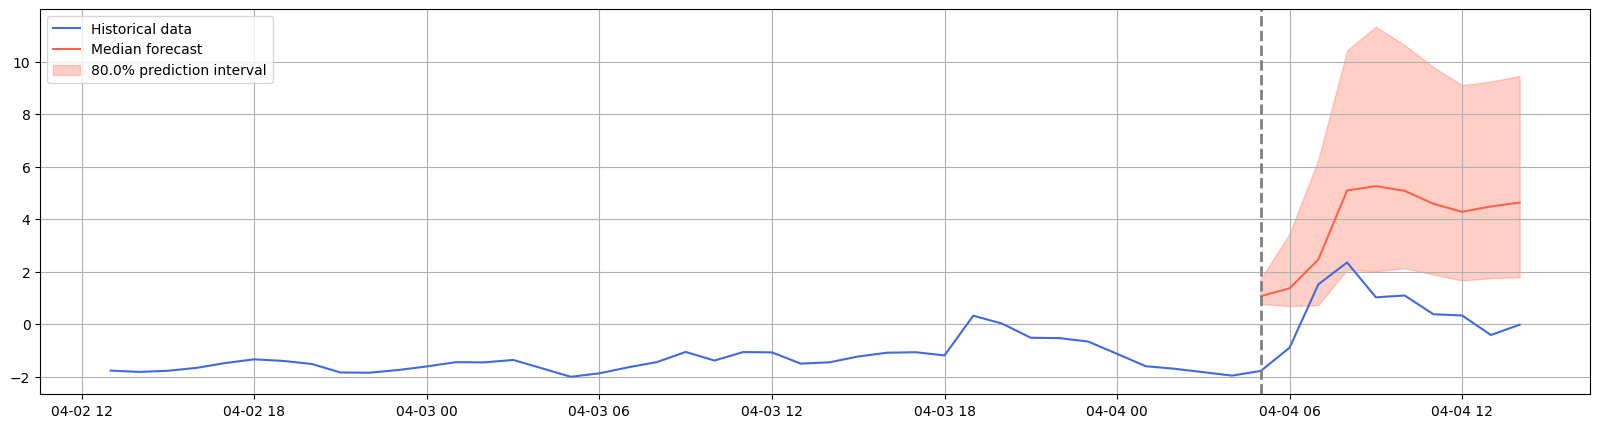

In [56]:
low, median, high = predictions3.loc[:, "0.1"], predictions3.loc[:, "0.5"], predictions3.loc[:, "0.9"]
start_forecasting_date = test_data.index.get_level_values("timestamp")[-prediction_length]
plot_timeseries_forecasting(temp_df.tail(50), low, median, high,
                            start_forecasting_date=start_forecasting_date,
                            prediction_length=prediction_length, freq='h')

## XGBoost

In [57]:
# XGBoosting.com
# Train an XGBoost Model for Multivariate Time Series Forecasting

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error




X = data.copy(deep=True).drop(columns=['C6H6(GT)']).values
y = data['C6H6(GT)'].copy(deep=True).values  # Predict series1

# Chronological split of data into train and test sets

X_train, X_test = X[:-15], X[-15:]
y_train, y_test = y[:-15], y[-15:]

# Initialize an XGBRegressor model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 0.0051


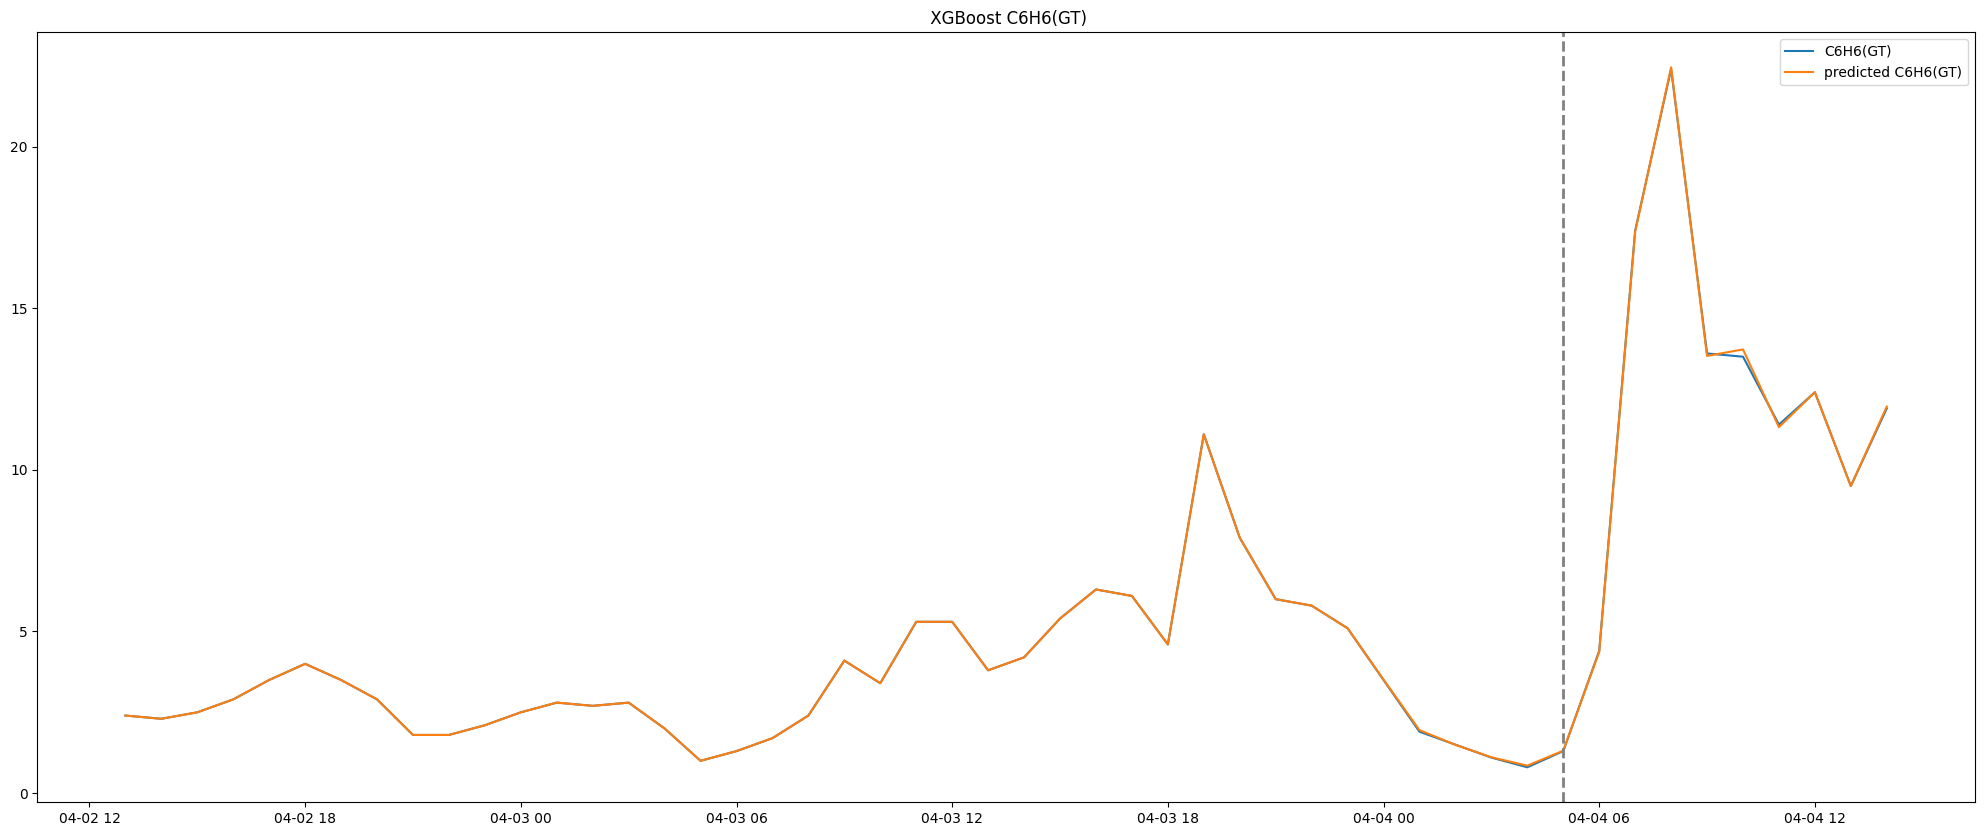

In [59]:
plt.figure(figsize=(25,10))
plt.plot(data.index.values[-50:], np.concat([y_train[-35:],y_test]), label='C6H6(GT)')
plt.plot(data.index.values[-50:], np.concat([y_train[-35:],y_pred]), label='predicted C6H6(GT)')
plt.axvline(x=start_forecasting_date, color='gray', linestyle='--', linewidth=2)
plt.title(' XGBoost C6H6(GT)')
plt.legend(loc='best')